# Using random forest regressor to geolocate sample origin based on pollen composition
### Rebecca Hayes
### PhD Candidate
### University of Oregon

For this project, I explored different machine learning algorithms and assessed their ability and accuracy in predicting location of origin of bee samples using the plant species composition identified from the DNA sequences of pollen that each bee was carrying. To do this, I used bee samples from two previous projects conducted by my PI; the first took place in the Madrean Sky Islands archipelago in Arizona and New Mexico, while the second took place in California industrial sunflower fields. The motivation for this project is to determine the most effective algorithm to predict location of origin of a pollen sample in an applied forensic palynology context. This notebook is an example of the best performing algorithm. See below interactive map to explore the real and predicted sample locations.

In [1]:
#import necessary packages/modules
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from sklearn import datasets
from sklearn import linear_model

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# figure parameters
plt.rcParams['figure.figsize'] = [10, 5]

### Data wrangling

In [3]:
#data imports
df_si = pd.read_csv("spec_RBCL_16s.csv", low_memory=False)
df_ffar = pd.read_csv("FFARspec.csv", low_memory=False)

In [4]:
#data manipulations
#################################################################################################
#adding a column for day of year
import datetime
fmt = '%Y-%m-%d'
s = [col for col in df_si['Date']]

#function to determine day of year for sample collection
def get_doy(s):
    doys = []
    for i in s:
        dt = datetime.datetime.strptime(i, fmt)
        tt = dt.timetuple()
        doys.append(tt.tm_yday)
    return doys
date_of_year = get_doy(s)

#add column to store day of year
df_si['DOY'] = date_of_year

#add column to store the genus and species
df_si['GenSp'] = df_si['Genus'] + '.' + df_si['Species']

#isolate the columns that start with RBCL: these are the columns that hold the RBCL relative abundance
rbcl_cols = [col for col in df_si if col.startswith('RBCL')]

#specify which columns we want to keep
my_cols = ['UniqueID', 'Family', 'Genus', 'GenSp', 'Site', 'Lat', 'Long', 'DOY'] + rbcl_cols
df_si = df_si.reindex(columns=my_cols)

#get rid of nas
df_si1 = df_si.dropna(subset=[i for i in rbcl_cols], how='all')
df_si1 = df_si1.fillna(0)

#optional: save output
#df_ffar1.to_csv('C://Users/rah10/Documents/1ROTATION kern lab/FFARbeeRBCL.csv')
df_si1


###########################################################################################
#repeat for ffar project data
df_ffar = pd.read_csv("FFARspec.csv", low_memory=False)
#adding a column for day of year
import datetime
fmt = '%Y-%m-%d'
q = [col for col in df_ffar['Date']]

def get_doy(q):
    doys = []
    for i in q:
        dt = datetime.datetime.strptime(i, fmt)
        tt = dt.timetuple()
        doys.append(tt.tm_yday)
    return doys

date_of_year_2 = get_doy(q)

df_ffar['DOY'] = date_of_year_2
df_ffar['GenSp'] = df_ffar['Genus'] + '.' + df_ffar['Species']
rbcl_cols2 = [col for col in df_ffar if col.startswith('RBCL')]
my_cols2 = ['UniqueID', 'Family', 'Genus', 'GenSp', 'Site', 'Lat', 'Long', 'DOY'] + rbcl_cols2
df_ffar = df_ffar.reindex(columns=my_cols2)
df_ffar1 = df_ffar.dropna(subset=[i for i in rbcl_cols2], how='all')
df_ffar1 = df_ffar1.fillna(0)
#df_ffar1.to_csv('C://Users/rah10/Documents/1ROTATION kern lab/FFARbeeRBCL.csv')

#########################################################################################################

#join the datasets
df_all = pd.concat([df_si1,df_ffar1], axis=0, ignore_index=True)

#fix induced nas
df_all = df_all.fillna(0)

In [5]:
#tutorial for creating X and y in preparation for linear regression 
#https://ai-ml-analytics.com/creating-feature-and-target-matrix-from-a-dataset/

#store columns that start with rbcl
rbcl_cols = [col for col in df_all if col.startswith('RBCL')]

#keep the feature columns and target columns
my_cols = ['Lat', 'Long', 'DOY'] + rbcl_cols
df_all = df_all[my_cols]
df_all = df_all.reindex(columns=my_cols)

#create the features
X = df_all.drop('Lat',axis=1)
X = X.drop('Long',axis=1)

#create the targets
lat = np.array(df_all['Lat'])
long = np.array(df_all['Long'])
y = np.column_stack((lat, long)) 

Training Set Mean Accuracy = 1.0
Test Set Mean Accuracy = 0.99
R2 =  0.9909049101545973
mse =  0.10170681281210812


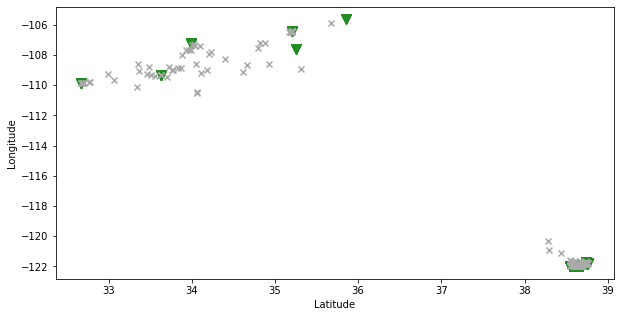

In [6]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)
    
# Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test  = sc_X.transform(X_test)

# Random forest
from sklearn.ensemble import RandomForestRegressor
#rf =RandomForestRegressor(max_depth=2, n_estimators = 100, random_state=0) ###original
rf =RandomForestRegressor(n_estimators = 400, min_samples_split = 2, min_samples_leaf = 1, max_features = 'sqrt', max_depth = None, bootstrap = False) ###tuned
rf = rf.fit(X_train,y_train)
pred_train = rf.predict(X_train)
pred_test = rf.predict(X_test)

#determine error between training and test data
train_error = np.round(rf.score(X_train, y_train), 2)
test_error = np.round(rf.score(X_test, y_test), 2)    
print("Training Set Mean Accuracy = " + str(train_error))
print("Test Set Mean Accuracy = " + str(test_error))

#determine r^2 and mean squared error between test data and predictions
print("R2 = " + " " + str(r2_score(y_test,pred_test)))
print("mse = " + " " + str(mean_squared_error(y_test,pred_test)))

#prepare test and predictions for plotting
y_test = np.hsplit(y_test, 2)
pred_test = np.hsplit(pred_test, 2)

#create scatter plot with green triangles for test points and gray X for predicted points
plt.scatter(y_test[0], y_test[1], marker='v', s=100, color='forestgreen')
plt.scatter(pred_test[0], pred_test[1], color='darkgray', marker='x')
plt.xlabel("Latitude")
plt.ylabel("Longitude");

Most Important Features


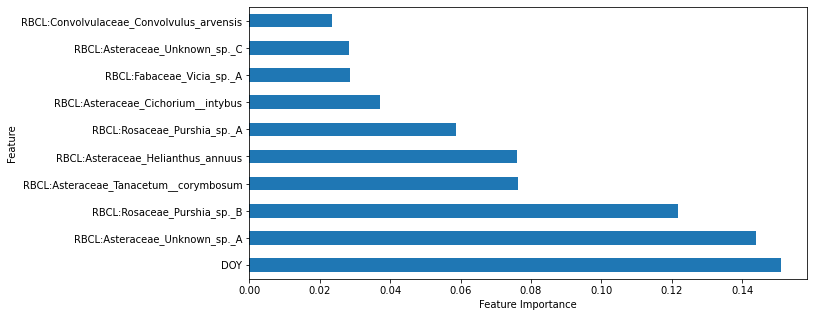

In [7]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
names = np.load('X_cols.npy', allow_pickle = True)
#reg= ExtraTreesRegressor()
rf.fit(X_train,y_train)
importance = rf.feature_importances_
#print(np.column_stack((names, importance)))
feat_importances = pd.Series(rf.feature_importances_, index=names)
print('Most Important Features')
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

In [8]:
#prepare points from test and predictions for plotting
y_test_new = np.column_stack((y_test[0],y_test[1])) 
preds_new = np.column_stack((pred_test[0],pred_test[1])) 
y_and_preds = np.concatenate((y_test_new,preds_new),axis=1)

import folium
from math import atan 
from folium.plugins import MarkerCluster

#function to return a list of the geographic distance between test and predicted location
from geopy.distance import geodesic
def get_dists(real_predicted_coords):
    dists_list = []
    for line in real_predicted_coords:
        x = geodesic([line[0],line[1]], [line[2],line[3]]).km
        dists_list.append(x)
    return dists_list
    
dists = get_dists(y_and_preds)

#function to assign colors based on binned distance between real and predicted points
#precitions that are less than or equal to 5km from the true location will be connected with a green segment
#predictions that are between 5 and 15 km away from the true location will be connected with an orange segment
#predictions more than 15 km away from the true location will be connected with a red segment
def assign_colors(dist_list):
    color_pick = []
    for lens in dists:
        if lens <= 5:
            color_pick.append('Green')
        elif 5 < lens <= 15:
            color_pick.append('Orange')
        elif lens > 15:
            color_pick.append('Red')
    return color_pick

my_colors = assign_colors(dists) 


#create base map
mapit = folium.Map( location=[36.1699, -115.1398], zoom_start=5, control_scale=True)
folium.TileLayer('cartodbpositron').add_to(mapit)

#add segments connecting real and predicted locations
marker_len = 0
for coord in y_and_preds:
    folium.PolyLine(locations = ([ coord[0], coord[1] ], [coord[2], coord[3]]), color=my_colors[marker_len]).add_to(mapit)
    marker_len += 1

#add small gray circles marking predicted locations    
for coord in preds_new:
    folium.CircleMarker( location=[ coord[0], coord[1] ], color="darkgray", radius=5, fill_color='gray', fill=True ).add_to( mapit )
    marker_cluster1 = MarkerCluster().add_to(mapit)
for coord in preds_new:
   folium.CircleMarker(location=[ coord[0], coord[1] ], color="darkgray", radius=5, fill_color='gray', fill=True).add_to(marker_cluster1)

   
#add larger green circles marking true locations      
for coord in y_test_new:
    folium.CircleMarker( location=[ coord[0], coord[1] ], color="green", fill_color='green', radius=10 ).add_to( mapit )    
marker_cluster = MarkerCluster().add_to(mapit)
for coord in y_test_new:
    folium.CircleMarker(location=[ coord[0], coord[1] ], color="green", fill_color='lightgreen', radius=10 ).add_to(marker_cluster)
    

for coord in preds_new:
   folium.CircleMarker(location=[ coord[0], coord[1] ], icon=folium.Icon(color="gray",icon="question-circle-o", prefix='fa')).add_to(marker_cluster1)


This map shows actual data points with green circle markers, while predictions are plotted with smaller gray circle markers. In places where several markers overlap, they are marked with a circle and overlayed with the number of points underneath it, and the points can be zoomed in and spread out by clicking the circle. The circles are colored by marker density, with green to yellow to orange signifying increasing number of points respectively. Line segments connect the actual points and the predicted points, with segment color corresponding to distance apart, with green = 5 km or less, orange = 5-15 km, and red = more than 15 km. 

In [9]:
mapit

Between projects, no samples were incorrectly sorted. 

In [10]:
#find the difference between real and predicted points -- longitude
long_diff = abs(y_and_preds[:, 0]-y_and_preds[:, 2])

In [11]:
#find the difference between real and predicted points -- latitude
lat_diff = abs(y_and_preds[:, 1]-y_and_preds[:, 3])

In [12]:
#average difference in longitude between real and predicted point
np.average(long_diff)

0.0767009707296339

In [13]:
#median difference in longitude between real and predicted point
np.median(long_diff)

0.0268087897500493

In [14]:
#average difference in latitude between real and predicted point
np.average(lat_diff)

0.14431833044793654

In [15]:
#median difference in latitude between real and predicted point
np.median(long_diff)

0.0268087897500493

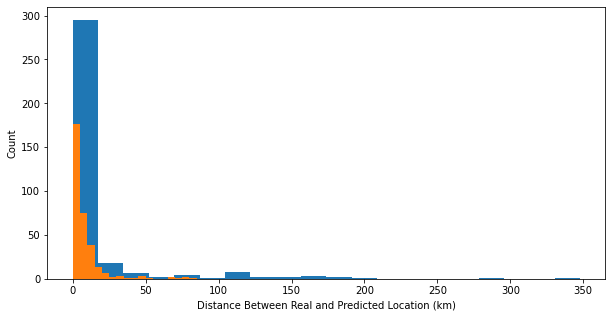

In [16]:
#distribution of distances between real and predicted points
plt.hist(dists, bins=20)
plt.hist(dists, bins=20, range=(0,100))
plt.xlabel("Distance Between Real and Predicted Location (km)")
plt.ylabel("Count");

The majority of pairs of true and predicted points had a relatively low distance difference. 